In [47]:
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

# Step 1: Download and preprocess the data
# Download historical VIX data
data = yf.download('^VIX', start='2019-01-01', end='2024-11-01', interval='1d')

# Select the "Close" column as the target and drop NaN values
data = data[['Close']].dropna()

# Create features and targets using lag features
n_lags = 5  # Number of past days to use as input features
X, y = [], []

for i in range(n_lags, len(data)):
    X.append(data['Close'].iloc[i-n_lags:i].values)
    y.append(data['Close'].iloc[i])

X, y = np.array(X), np.array(y)


[*********************100%***********************]  1 of 1 completed


In [48]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape X for scaling: Flatten the 3D array to 2D (n_samples, n_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_samples, n_lags)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)    # Shape: (n_samples, n_lags)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

In [49]:
# Step 2: Build the Multilayer Perceptron (MLP) model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Hidden layer 1
    Dense(32, activation='relu'),                                         # Hidden layer 2
    Dense(1)                                                              # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Step 3: Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss (MSE): {loss}, Test MAE: {mae}")

# Step 5: Make predictions and visualize results
y_pred = model.predict(X_test_scaled)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.0233 - mae: 22.1497 - val_loss: 308.4036 - val_mae: 17.3005
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 554.3840 - mae: 21.9143 - val_loss: 258.9266 - val_mae: 15.8386
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 427.5678 - mae: 19.1472 - val_loss: 157.4066 - val_mae: 12.3129
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 237.6084 - mae: 14.2119 - val_loss: 43.5351 - val_mae: 6.3576
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.0488 - mae: 6.5819 - val_loss: 1.9298 - val_mae: 0.9989
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 8.1313 - mae: 1.8959 - val_loss: 2.7866 - val_mae: 1.3979
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 9.0086 - mae: 1.9428 - val_loss: 2.2449 - val_mae: 1.2033
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 9.2687 - mae: 1.9540 - val_loss: 2.1531 - val_mae: 1.1666
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 92

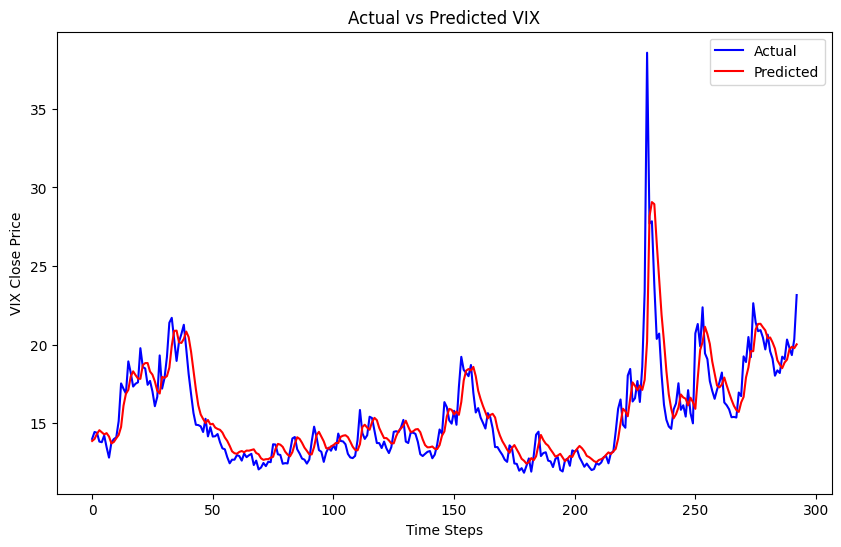

In [51]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted VIX')
plt.xlabel('Time Steps')
plt.ylabel('VIX Close Price')
plt.show()
